In [1]:
%matplotlib inline

import os
import numpy as np
import cv2
import torch

from generic_pose.eval.multi_object_pose_estimator import MultiObjectPoseEstimator
from generic_pose.utils import to_np

from generic_pose.utils.image_preprocessing import cropBBox, seg2Mask, unprocessImages
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12

In [2]:
def imshowCV(img, axis = False):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [3]:
annotation_path = '/home/bokorn/data/surgical/images/coco/annotations/instances_train2014.json'
image_path = '/home/bokorn/data/surgical/images/coco/coco_train2014/'

weight_paths = ['/home/bokorn/data/surgical/weights/hemostat_black/weights.pth', ]
render_paths = ['/home/bokorn/data/surgical/weights/hemostat_black/', ]
object_models = ['/home/bokorn/data/surgical/models/hemostat/hemostat_black.obj', ]

category_names = 'hemostat'
f = 570.3422241210938
p = (319.5, 238.5)
idx = 10

pose_estimator = MultiObjectPoseEstimator(weight_paths=weight_paths,
                                          render_paths=render_paths,
                                          focal_length=f, image_center=p,
                                          object_models=None,)

In [4]:
coco = COCO(annotation_path)
cat_ids = coco.getCatIds(catNms=category_names)
cats = coco.loadCats(cat_ids)
img_ids = coco.getImgIds(catIds=cat_ids)
ann_ids =  coco.getAnnIds(catIds=cat_ids)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


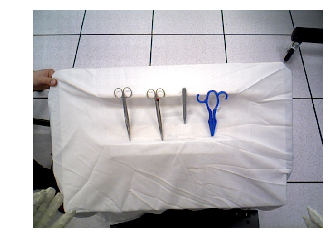

In [5]:
ann_info = coco.loadAnns(ann_ids[idx])[0]
img_info = coco.loadImgs(ann_info['image_id'])[0]
img = cv2.imread(os.path.join(image_path, img_info['file_name']))
imshowCV(img)

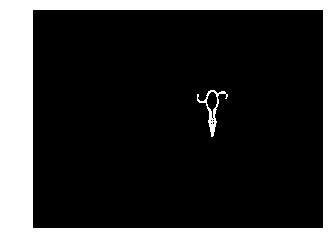

In [6]:
disp_img = img.copy()
mask = seg2Mask(ann_info['segmentation'], img.shape)
disp_mask = np.concatenate([255*mask.astype(np.uint8),]*3, axis=2)
imshowCV(disp_mask)


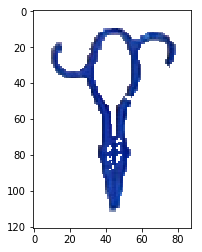

In [7]:
bbox = ann_info['bbox']  
img_crop, corner = cropBBox(np.concatenate([img, mask], axis=2), 
                            bbox)
img_mask = img_crop[:,:,:3] * img_crop[:,:,3:] + 255*(1-img_crop[:,:,3:])
imshowCV(img_mask, axis=True)

In [8]:
pose_estimator.renderer = None
#class_idx = 0
#poses, mode_idxs = pose_estimator.pose_estimators[class_idx].getPose(img_mask)
#print(mode_idxs)
t, quat, template = pose_estimator(img_mask, 0, corner)

In [14]:
img.shape

(480, 640, 3)

## Only run if you have blender install as a python model

In [10]:
from model_renderer.pose_renderer import BpyRenderer
from generic_pose.datasets.ycb_dataset import ycbRenderTransform
from generic_pose.utils import to_np
from quat_math import quaternion_matrix, euler_matrix

In [11]:
renderer = BpyRenderer(transform_func = ycbRenderTransform)
renderer.loadModel(object_models[0], emit = 0.5)
#renderer.setCameraMatrix(fx = f, fy = f, px = p[0], py = p[1], 
#                         w = img.shape[1], h = img.shape[0])
h, w = img.shape[:2]
px, py = p

#renderer.bpy.data.scenes['Scene'].unit_settings.system = 'METRIC'
w_s = renderer.bpy.data.cameras['Camera'].sensor_width
f_mm = f/w*w_s
renderer.cam_obj.data.lens = f_mm
renderer.bpy.context.scene.render.resolution_x = w
renderer.bpy.context.scene.render.resolution_y = h
renderer.bpy.context.scene.render.resolution_percentage = 100


renderer.cam_obj.data.shift_x = (w/2 - px)/w
renderer.cam_obj.data.shift_y = (h/2 - py)/h

(  0.0001 sec |   0.0001 sec) Importing OBJ '/home/bokorn/data/surgical/models/hemostat/hemostat_black.obj'...
  (  0.0006 sec |   0.0005 sec) Parsing OBJ file...
    (  0.0404 sec |   0.0398 sec) Done, loading materials and images...
    (  0.0412 sec |   0.0405 sec) Done, building geometries (verts:2597 faces:5192 materials: 1 smoothgroups:0) ...
    (  0.0640 sec |   0.0634 sec) Done.
  (  0.0641 sec |   0.0640 sec) Finished importing: '/home/bokorn/data/surgical/models/hemostat/hemostat_black.obj'
Progress: 100.00%



Rotation: [-0.00367244  0.2012336  -0.03191192 -0.9790164 ]
Translation: [ 0.1076044  -0.00914286  0.80223961]
[[ 0.91697334  0.39378761 -0.06396263  0.1076044 ]
 [ 0.06100656  0.02003426  0.99793628 -0.00914286]
 [ 0.39425639 -0.9189831  -0.00565275  0.80223961]
 [ 0.          0.          0.          1.        ]]


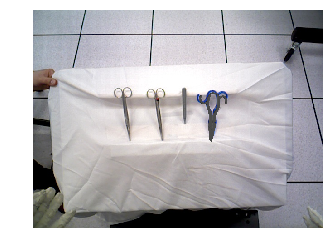

In [12]:
#f_t = 35/1000
#f_i = f / 1000
#tz = template_dist * diag_t/diag * f/f_t
#ty = tz / f * (y - p[0])
#tx = tz / f * (x - p[1])

#t = [ty, tx, tz]

#quat = to_np(quats[0])

print('Rotation:', quat)
print('Translation:', t)

mat = quaternion_matrix(quat)
ycb_mat = euler_matrix(-np.pi/2,0,0)
mat = mat.dot(ycb_mat)
mat[:3,3] = t
#mat[:3,3] = [0.0,0,1.23]
#mat[:3,3] = [ty, -tx, tz]
print(mat)

render_img = renderer.renderTrans(mat)
render_mask = render_img[:,:,3:]/255.0

disp_img = img * (1-render_mask) +  render_img[:,:,:3]
disp_img = disp_img.astype(np.uint8)
#imshowCV(render_img)
#imshowCV(img)

imshowCV(disp_img)